In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy as dup
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from matplotlib.gridspec import GridSpec

# My modules
# import sys; sys.path.append('..')
import QLCstuff2 as QLC; reload(QLC)

<module 'QLCstuff2' from '/Users/nesh/Documents/Repositories/icecontinuum/nesh/Code and figures for continuum paper/QLCstuff2.py'>

In [11]:
# Graphics parameters
%matplotlib inline
ticklabelsize = 11
fontsize = 15
linewidth = 2

In [12]:
# Testing formulas
L = AssignQuantity(50,'micrometers')
Pressure = AssignQuantity(68.6,'Pa')
Temperature = AssignQuantity(240,'K')
print('Test 1 (reference case)')
print(QLC.get_L_cr_of_P(Pressure,AssignQuantity))
print(QLC.get_L_cr_of_T(Temperature,AssignQuantity))
print(QLC.get_cr_of_T(L,Temperature,AssignQuantity))
print(QLC.get_cr_of_P(L,Pressure,AssignQuantity))
print(QLC.get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')

print('Test 2 (changing temperature)')
L = AssignQuantity(100,'micrometers')
Pressure = AssignQuantity(68.6,'Pa')
Temperature = AssignQuantity(250,'K')
print(QLC.get_L_cr_of_P(Pressure,AssignQuantity))
print(QLC.get_L_cr_of_T(Temperature,AssignQuantity))
print(QLC.get_cr_of_T(L,Temperature,AssignQuantity))
print(QLC.get_cr_of_P(L,Pressure,AssignQuantity))
print(QLC.get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')

print('Test 3 (changing pressure)')
L = AssignQuantity(50,'micrometers')
Pressure = AssignQuantity(500,'Pa')
Temperature = AssignQuantity(240,'K')
print(QLC.get_L_cr_of_P(Pressure,AssignQuantity))
print(QLC.get_L_cr_of_T(Temperature,AssignQuantity))
print(QLC.get_cr_of_T(L,Temperature,AssignQuantity))
print(QLC.get_cr_of_P(L,Pressure,AssignQuantity))
print(QLC.get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')

print('Test 4 (changing temperature and pressure)')
L = AssignQuantity(50,'micrometers')
Pressure = AssignQuantity(500,'Pa')
Temperature = AssignQuantity(250,'K')
print(QLC.get_L_cr_of_P(Pressure,AssignQuantity))
print(QLC.get_L_cr_of_T(Temperature,AssignQuantity))
print(QLC.get_cr_of_T(L,Temperature,AssignQuantity))
print(QLC.get_cr_of_P(L,Pressure,AssignQuantity))
print(QLC.get_cr_of_TP(L,Temperature,Pressure,AssignQuantity))
print('')

Test 1 (reference case)
175.25975096790899
175.77751197212177
0.2844504933482616 micrometer
0.28529083103145153 micrometer
0.28529083103145153 micrometer

Test 2 (changing temperature)
175.25975096790899
471.0524557440127
0.21229058203730858 micrometer
0.5705816620629031 micrometer
0.2129177413498919 micrometer

Test 3 (changing pressure)
19.871377441811234
175.77751197212177
0.2844504933482616 micrometer
2.5161818875623254 micrometer
2.5161818875623254 micrometer

Test 4 (changing temperature and pressure)
19.871377441811234
471.0524557440127
0.10614529101865429 micrometer
2.5161818875623254 micrometer
0.9389361767925446 micrometer



### The cell below specifies parameters for the 0-d and 1-d runs

In [157]:
#Setting up the system

# Crystal size
L = 50 # micrometers
print('L = ',L)

# This is the temperature
Temperature = AssignQuantity(240,'K')
print('Temperature = ',Temperature)

# This is the pressure
Pressure = AssignQuantity(50,'Pa')
print('Ambient pressure = ',Pressure)

# Temperature- and pressure-dependent center reduction
Iwantcalculated_center_reduction = False
if Iwantcalculated_center_reduction:
    center_reduction = get_cr_of_TP(L,Temperature,Pressure,AssignQuantity)
    print('Calculating a center reduction')
    print('   Lcr = ', L/center_reduction)
    print('   Lcr = ', get_L_cr_of_TP(Temperature,Pressure,AssignQuantity))
    print('   center_reduction = ',center_reduction)
else:
    print('Assigning a center reduction')
    center_reduction = 0.376
    print('   Lcr = ', L/center_reduction)
    print('   center_reduction = ',center_reduction)
c_r = center_reduction/100
center_reduction_ref = center_reduction

# Surface diffusion coefficient
Iwantcalculated_D = False
if Iwantcalculated_D:
    print('Calculating the surface diffusion coefficient')
    D = QLC.get_D_of_T(Temperature,AssignQuantity)
    print('   D = ',D)
    D = D.magnitude
else:
    print('Assigning a surface diffusion coefficient')
    D = 7e-3 # micrometers^2/microsecond
    D = 5e-4 # micrometers^2/microsecond
    print('   D = ',D)
    
# Kinetic velocity
Iwantcalculated_nu_kin = True
if Iwantcalculated_nu_kin:
    print('Calculating a kinetic velocity')
    nu_kin = QLC.get_nu_kin(Temperature,AssignQuantity)
    print('   nu_kin = ',nu_kin)
    nu_kin = nu_kin.magnitude
else:
    print('Assigning a kinetic velocity')
    nu_kin = 34 # microns/second - about right for 240 K
    print('   nu_kin = ',nu_kin)
    
# Supersaturations relative to microstate I
row_number = 1
if row_number == 1:
    sigmaIstyle = 'parabolic'
    figurename_growth_and_ablation = 'Figure - growth_and_ablation, row 1.png'
    sigmaIcorner = 0.22; print('   sigmaIcorner = ', sigmaIcorner)
    sigma0 = 0.2; print('   sigma0 = ', sigma0)
    tlast_msec = 150; print('   time (used) = ',tlast_msec)
elif row_number == 2:
    sigmaIstyle = 'sinusoid'; nsinusoid=3
    figurename_growth_and_ablation = 'Figure - growth_and_ablation, row 2.png'
    sigmaIcorner = 0.22; print('   sigmaIcorner = ', sigmaIcorner)
    sigma0 = 0.2; print('   sigma0 = ', sigma0)
    tlast_msec = 75; print('   time (used) = ',tlast_msec)
elif row_number == 3:
    sigmaIstyle = 'parabolic'
    figurename_growth_and_ablation = 'Figure - growth_and_ablation, row 3.png'
    sigmaIcorner = -0.2; print('   sigmaIcorner = ', sigmaIcorner)
    sigma0 = 0.2; print('   sigma0 = ', sigma0)
    tlast_msec = 500; print('   time (used) = ',tlast_msec)
else:
    print('oops')
    kill = np.sqrt(-1)

# Estimating/deciding on how long to make the integration
print('times')
# tlast_estimated = (L/D)**.5*1.5; print('   time (est) = ', tlast_estimated)
tlast_estimated = (L/D)**.5; print('   time (est) = ', tlast_estimated)
# tlast_msec = tlast_estimated; print('   time (used) = ',tlast_msec)

# Supposedly, we can predict some values
lambda_go_fit = 9.648864395081624
x_go_fit =  6.338904071061348
x_trial = sigmaIcorner-sigma0
m_g_fit =  1.2348433873976625
b_g_fit =  -0.23822225777997208
D_ref = 1.0e-3; nu_kin_ref = 34; c_r_ref = 0.00284
print('zparameters')
# zparam_ref = (D_ref/(c_r_ref*nu_kin_ref))**.5*100; print('   zparam_ref = ',zparam_ref)
# zparam = (D/(c_r*nu_kin))**.5*100; print('   zparam = ',zparam)
# zformularatio = (m_g_fit*zparam+b_g_fit)/(m_g_fit*zparam_ref+b_g_fit)
# lambda_g_predicted = lambda_go_fit*(1 - np.exp(-1/((sigmaIcorner-sigma0)*x_go_fit)))*zformularatio
# print('   lambda_g_predicted = ', lambda_g_predicted)

L =  50
Temperature =  240 kelvin
Ambient pressure =  50 pascal
Assigning a center reduction
   Lcr =  132.9787234042553
   center_reduction =  0.376
Assigning a surface diffusion coefficient
   D =  0.0005
Calculating a kinetic velocity
   nu_kin =  39.341788071548116 micrometer / second
   sigmaIcorner =  0.22
   sigma0 =  0.2
   time (used) =  150
times
   time (est) =  316.22776601683796
zparameters


In [159]:
nx = int(501*L/75)
xmax = 2*L

# nx = 801; xmax = 150*nx/501
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
# xmax = x[nx-1]
# L = xmax/2
tau_eq = 1

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
nu_kin_mlyperus_ref = nu_kin_mlyperus
Doverdeltax2 = D/deltax**2

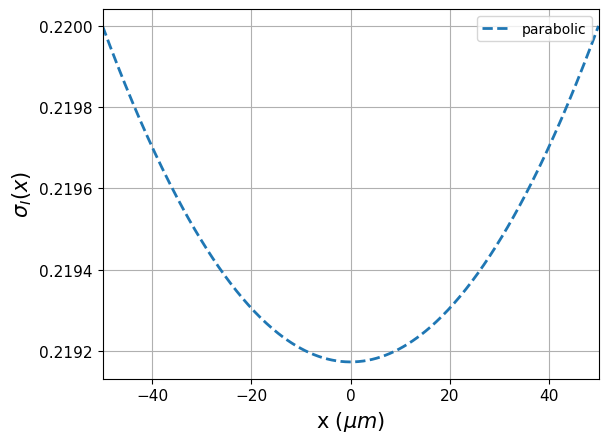

In [161]:
# Overlying supersaturation
if sigmaIstyle=='sinusoid':
    sigmaI = QLC.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid',nsinusoid=nsinusoid)
elif sigmaIstyle=='parabolic':
    sigmaI = QLC.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid, sigmaI, '--',lw=linewidth,label=sigmaIstyle)
plt.xlim([-xmid,xmid])
plt.legend()
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

In [163]:
# Integrator
odemethod ='LSODA' # results are a lot like DOP853, but faster

# Reporting
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')
print("nx =", nx)
print('tau_eq =', tau_eq, 'microseconds')

nu_kin_mlyperus = 0.13113929357182705 monolayers/us
nmid = 167
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3003003003003003
sigma_0 = 0.2
sigmaIcorner = 0.22
center reduction = 0.376 %
c_r = 0.00376 dimensionless
max growth rate = 8.655193375740586 um/sec
min growth rate = 0.7868357614309619 um/sec
nu_kin = 39.341788071548116 um/sec
dx = 0.3003003003003003
L = 50 micrometers
nx = 334
tau_eq = 1 microseconds


### This is the 0-d run

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
0-D Modeled growth rate, um/s 2.46783872362366
0-D Modeled growth rate, ml/us 0.008226129078745533
0-D Modeled alpha 0.2851280862817809
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
0-D Modeled growth rate, um/s 2.4655525497835464
0-D Modeled growth rate, ml/us 0.008218508499278488
0-D Modeled alpha 0.28486394731447356
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
0-D Modeled growth rate, um/s 2.46320988413622
0-D Modeled growth rate, ml/us 0.008210699613787401
0-D Modeled alpha 0.2845932814211045


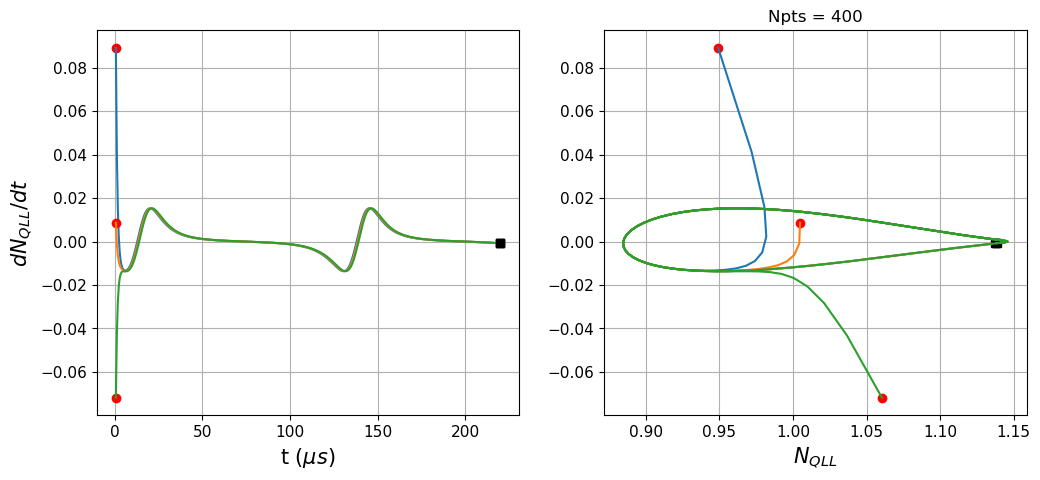

In [210]:
# Time steps
ntimes = 400
tlast = 220
tkeep_0Darr = np.linspace(0,tlast,ntimes)

# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus, tau_eq])

startfactor_range = np.linspace(0.9,1.1,3)
fig = plt.figure(figsize=(12,5))

for startfactor in startfactor_range:
    
    # Initialize as a pre-equilibrated layer of liquid over ice
    Ntot_init_0D = 0
    NQLL_init_0D = QLC.getNQLL(Ntot_init_0D,Nstar,Nbar)*startfactor
    
    # Solve
    Ntotkeep_0D, NQLLkeep_0D = QLC.run_f0d(NQLL_init_0D,Ntot_init_0D,tkeep_0Darr,params,odemethod)
    Nicekeep_0D = Ntotkeep_0D - NQLLkeep_0D
    
    # Growth statistics
    delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
    growthrate_0D_mlyperus = delta_Ntot_0D/tkeep_0Darr[-1] # monolayer/us
    growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
    print( "0-D Modeled growth rate, um/s", growthrate_0D)
    print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
    alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
    print( "0-D Modeled alpha", alpha_0D)
    title = '0D run, '+odemethod
    
    # # Plot results
    # plt.figure()
    # rcParams['xtick.labelsize'] = ticklabelsize 
    # rcParams['ytick.labelsize'] = ticklabelsize
    # plt.plot(tkeep_0Darr,NQLLkeep_0D,lw=linewidth,label='NQLL')
    # plt.plot(tkeep_0Darr,NQLLkeep_0D-QLC.getNQLL(Ntotkeep_0D,Nstar,Nbar),lw=linewidth,label='NQLL bias')
    # plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
    # plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
    # plt.grid('on')
    # plt.title(title)
    # plt.legend()
    
    # 1st derivative
    increment = 10
    back_from_end1 = 25
    dt = tkeep_0Darr[1]-tkeep_0Darr[0]
    dNQLL_dt = np.diff(NQLLkeep_0D)/dt
    back_from_end2 = back_from_end1*2
    back_from_end3 = back_from_end1*3
    back_from_end4 = back_from_end1*4
    fwd_from_start1 = 25
    fwd_from_start2 = fwd_from_start1*2
    fwd_from_start3 = fwd_from_start1*3
    
    plt.subplot(1,2,2)
    plt.plot(NQLLkeep_0D[1],dNQLL_dt[0],'or',label='start')
    # plt.plot(NQLLkeep_0D[1+fwd_from_start1],dNQLL_dt[fwd_from_start1],'og',label='start+'+str(fwd_from_start1))
    # plt.plot(NQLLkeep_0D[-back_from_end1],dNQLL_dt[-back_from_end1],'sb',label='end-'+str(back_from_end1))
    plt.plot(NQLLkeep_0D[-1],dNQLL_dt[-1],'sk',label='end')
    # plt.legend(loc='upper left')
    plt.plot(NQLLkeep_0D[1:],dNQLL_dt)
    plt.xlabel(r'$N_{QLL} $',fontsize=fontsize)
    # plt.ylabel(r'$dN_{QLL}/dt$',fontsize=fontsize)
    plt.grid(True)
    plt.title('Npts = '+str(len(NQLLkeep_0D)))
    
    plt.subplot(1,2,1)
    plt.plot(tkeep_0Darr[1],dNQLL_dt[0],'or',label='start')
    plt.plot(tkeep_0Darr[1:],dNQLL_dt)
    # plt.plot(tkeep_0Darr[1+fwd_from_start1],dNQLL_dt[fwd_from_start1],'og',label='start+'+str(fwd_from_start1))
    # plt.plot(tkeep_0Darr[1],dNQLL_dt[0],'or',label='start+'+str(fwd_from_start1))
    # plt.plot(tkeep_0Darr[-back_from_end1],dNQLL_dt[-back_from_end1],'sb',label='end-'+str(back_from_end1))
    plt.plot(tkeep_0Darr[-1],dNQLL_dt[-1],'sk',label='end')
    plt.ylabel(r'$dN_{QLL}/dt$',fontsize=fontsize)
    plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
    plt.grid(True)

figurename_0d_limit_cycle = 'Figure - zero-dimensional limit cycle.png'
fig.savefig(figurename_0d_limit_cycle, dpi=200)

### This is the 1-d run

dt = 5050.50505050505
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
1-D growth rate, ml/us -0.033987060040665686
1-D growth rate, um/s -10.196118012199706
1-D alpha 1.2958381547957034
Analysis of growth rates relative to 0D system
    1D, 0D alpha = 1.2958381547957034 1.3111220695951775
    1D ablation is slower by: 1.16 %
Libbrecht's predicted growth rate -3.2866988612922357 um/s
Libbrecht's predicted alpha 0.41771091533955573
horizontal layer speed (micrometers/microsecond) = -1.6993530020332843
nsteps average of last 30.0 % ( 30 points) = 12.459907055345333
estimated lambda = 4.012871025273809
estimated layer residence time (microseconds) = -2.3614110902634056


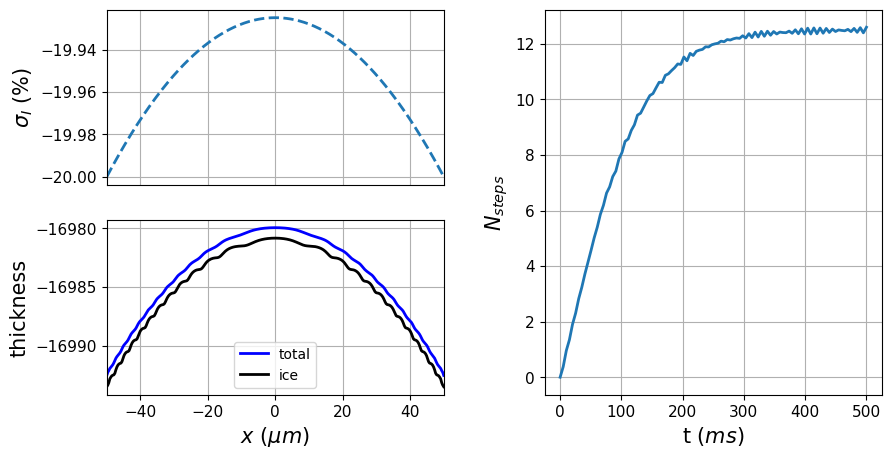

In [147]:
# Time steps
ntimes = 100
tlast = tlast_msec * 1000
tkeep_1Darr = np.linspace(0,tlast,ntimes)
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Bundle parameters for ODE solver
scalar_params = np.array([Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Solve
Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,scalar_params,sigmaI,odemethod)
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

# Stats
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
delta_alpha = (alpha_1D-alpha_0D)/alpha_0D*100; 
print('Analysis of growth rates relative to 0D system')
print("    1D, 0D alpha =", alpha_1D, alpha_0D)
if delta_Ntot_1D > 0: # Growing
    if delta_alpha < 0:
        print("    1D growth is slower by:", -int(delta_alpha*100)/100,'%')
    else:
        print("    1D growth is faster by:", int(delta_alpha*100)/100,'%')
else: # Ablating
    if delta_alpha < 0:
        print("    1D ablation is slower by:", -int(delta_alpha*100)/100,'%')
    else:
        print("    1D ablation is faster by:", int(delta_alpha*100)/100,'%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Horizontal speed of layers
HLS = growthrate_1D_mlyperus*L
print('horizontal layer speed (micrometers/microsecond) =',HLS)

# Other statistics prep
lastfraction = 0.3

# Graphics prep
title = 'D='+str(D)+', '+odemethod + ', tau='+str(tau_eq)+', $\sigma_I=$'+str(sigmaIcorner)

fig = plt.figure(figsize=(10,5))

gs = GridSpec(2, 2, wspace = .3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[:, -1])
ax3 = fig.add_subplot(gs[-1,0])

ax1.plot(x-xmid, sigmaI*100, '--',lw=linewidth,label=sigmaIstyle)
ax1.set_xlim([-xmid,xmid])
ax1.set_ylabel(r'$\sigma_I$ (%)',fontsize=fontsize)
ax1.grid('on')
ax1.set(xticklabels=[])  # remove the tick labels
ax1.tick_params(bottom=False)  # remove the ticks

# Plot number of steps over time
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
ax2.plot(tkeep_1Darr/1e3,f,lw=linewidth)
ax2.set_xlabel(r't ($m s$)',fontsize=fontsize)
ax2.set_ylabel(r'$N_{steps}$',fontsize=fontsize)
ax2.grid('on')

# Reporting
itimes_almost_end = int(ntimes*(1-lastfraction))
nsteps_ss = np.mean(f[itimes_almost_end:-1])
print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
lambda_average = L/nsteps_ss
print('estimated lambda =', lambda_average)
residence_time = lambda_average/HLS
print('estimated layer residence time (microseconds) =',residence_time)

# # Plot number of steps as vertical distance over time
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
# f *= nmpermonolayer
# plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
# plt.ylabel(r'vertical relief ($nm$)',fontsize=fontsize)
# plt.title(title)
# plt.grid('on')

# # Plot NQLL over time
# iposition1 = nmid; NQLL_in_equilibrium_with_Ntot_1 = QLC.getNQLL(Ntotkeep_1D[:,iposition1],Nstar,Nbar)
# iposition2 = -1;   NQLL_in_equilibrium_with_Ntot_2 = QLC.getNQLL(Ntotkeep_1D[:,iposition2],Nstar,Nbar)
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_1-NQLLkeep_1D[:,iposition1],lw=linewidth,label=str(x[iposition1]-xmid))
# plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_2-NQLLkeep_1D[:,iposition2],lw=linewidth,label=str(x[iposition2]-xmid))
# # plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
# plt.xlabel(r't ($m s$)',fontsize=fontsize)
# plt.ylabel(r'$N_{QLL} \ bias$',fontsize=fontsize)
# plt.title(title)
# plt.legend()
# plt.grid('on')

# Plot ice and total
itime = -1
ax3.plot(x-xmid, Ntotkeep_1D[itime,:], 'b', label='total', lw=linewidth)
ax3.plot(x-xmid, Nicekeep_1D[itime,:], 'k', label='ice', lw=linewidth)
ax3.set_xlabel(r'$x \ (\mu m$)',fontsize=fontsize)
# ax3.set_ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
ax3.set_ylabel('thickness',fontsize=fontsize)
ax3.set_xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# ax3.legend(loc='upper right')
ax3.legend()
# plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
ax3.grid('on')

# # Plot liquid
# itime = -1
# plt.figure()
# plt.plot(x-xmid, NQLLkeep_1D[itime,:], 'b', label='liquid', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
# plt.grid('on')

# Save
fig.savefig(figurename_growth_and_ablation, dpi=200)

dt = 2272.7272727272725
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.77569689]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.77569689 6.98047862]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.77569689 6.98047862 7.21986561]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.77569689 6.98047862 7.21986561 7.43406178]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.77569689 6.98047862 7.21986561 7.43406178 8.07992151]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.77569689 6.98047862 7.21986561 7.43406178 8.07992151 8.22528132]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.77569689 6.98047862 7.21986561

/var/folders/d4/79k8920n66j07rbcltjlhjx00000gr/T/ipykernel_62671/1566954071.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[ 6.77569689  6.98047862  7.21986561  7.43406178  8.07992151  8.22528132
  8.94934856  9.52257156  9.19774972  9.94817434 10.39008445 10.17530547
 10.92774412 11.17663405 11.31308367 11.30032987 11.94218539 12.24969797
 12.80891298 12.91679975 13.21679682 13.10944922]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[ 6.77569689  6.98047862  7.21986561  7.43406178  8.07992151  8.22528132
  8.94934856  9.52257156  9.19774972  9.94817434 10.39008445 10.17530547
 10.92774412 11.17663405 11.31308367 11.30032987 11.94218539 12.24969797
 12.80891298 12.91679975 13.21679682 13.10944922 13.64443679]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[ 6.77569689  6.98047862  7.21986561  7.43406178  8.07992151  8.22528132
  8.94934856  9.52257156  9.19774972  9.94817434 10.39008445 10.17530547
 10.

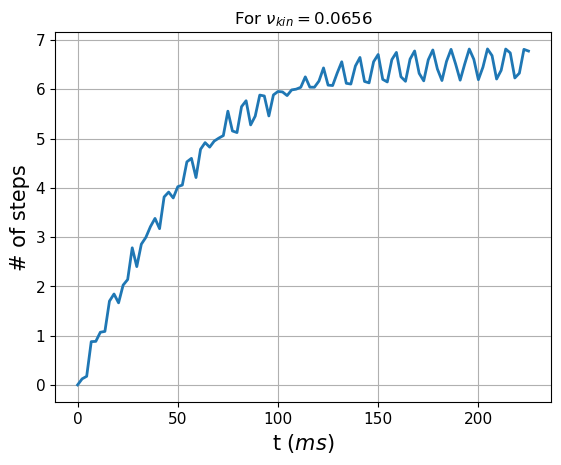

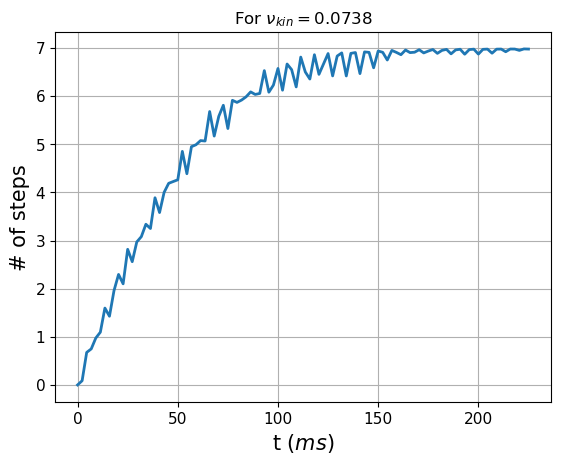

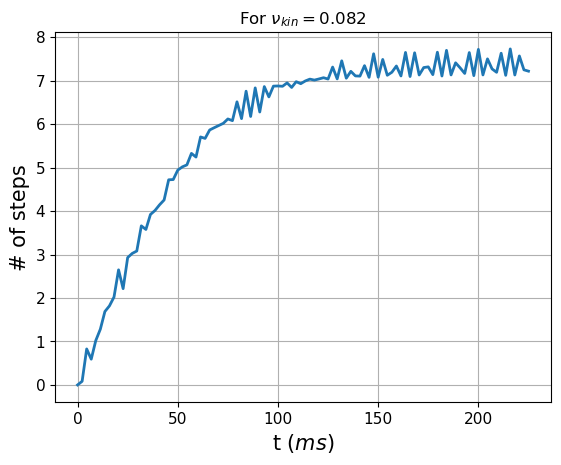

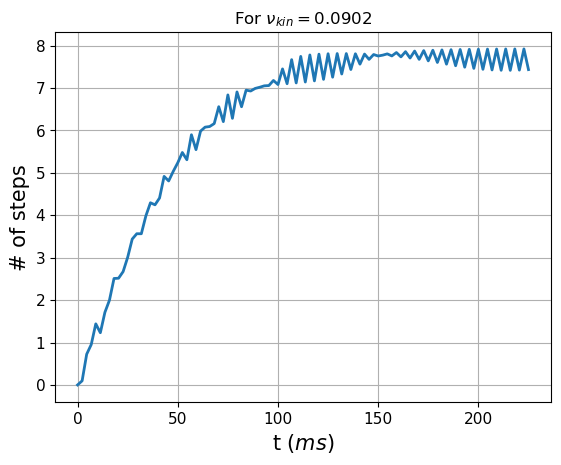

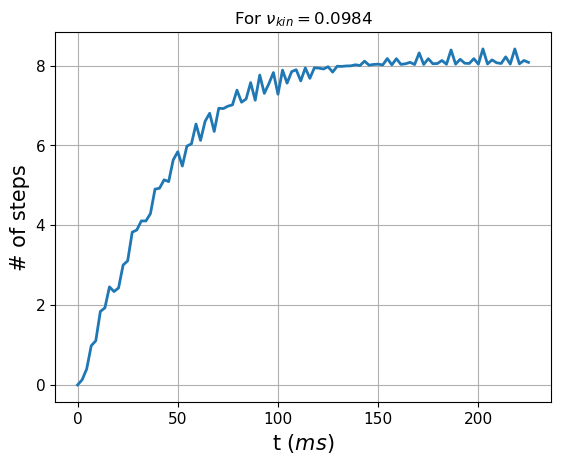

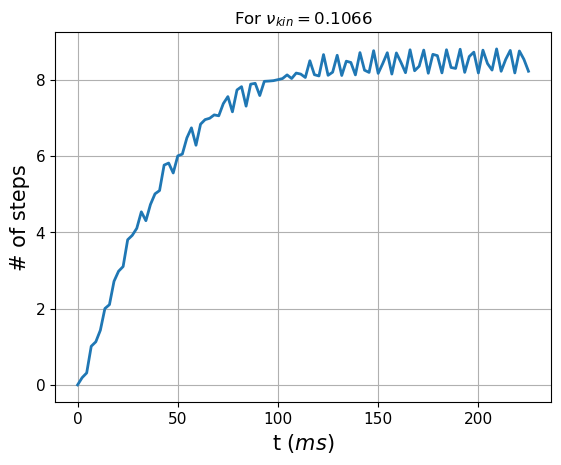

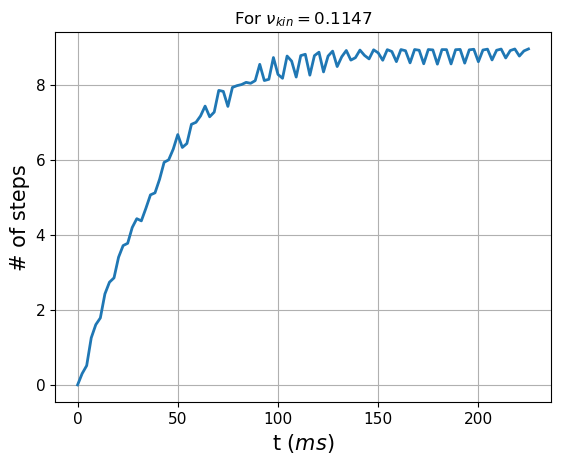

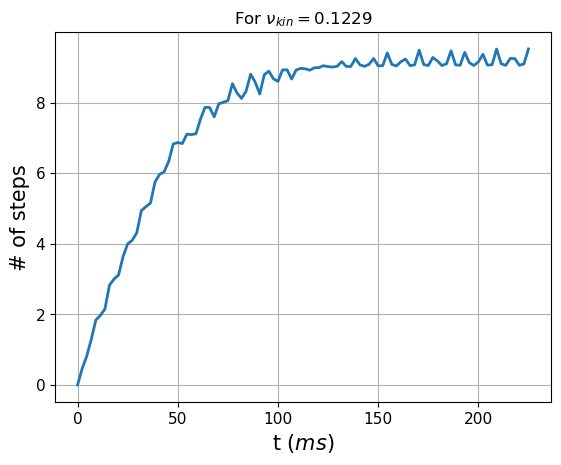

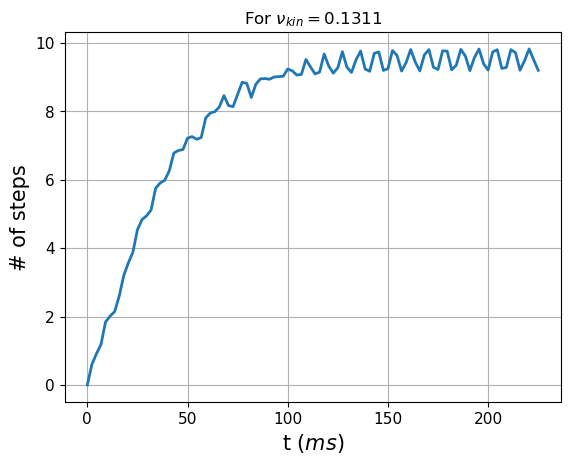

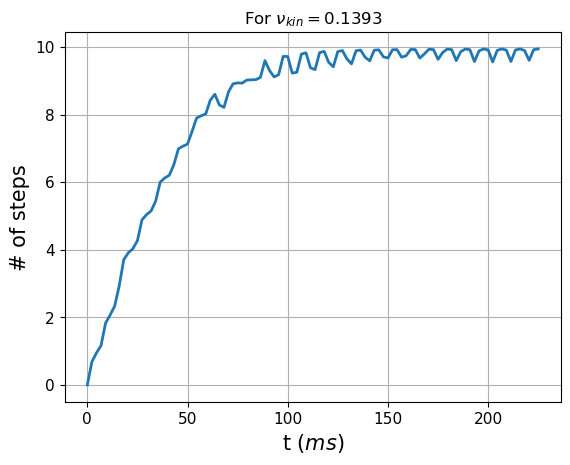

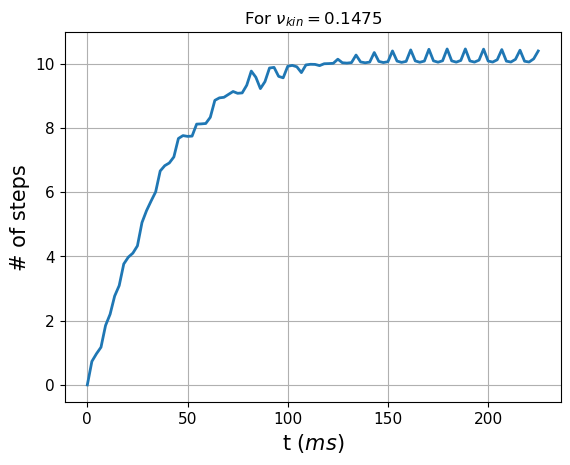

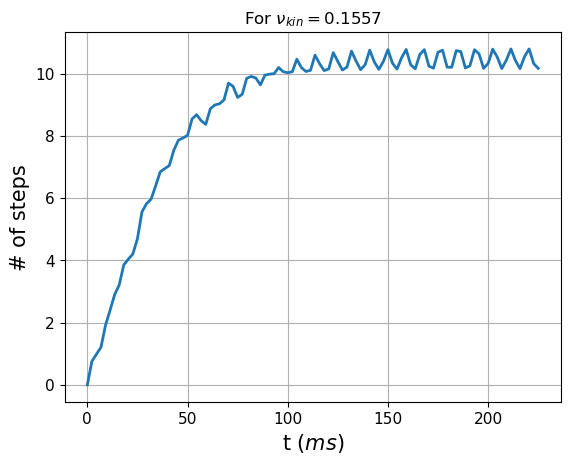

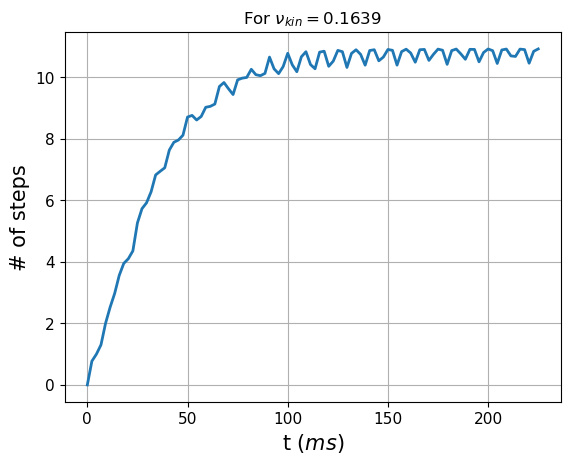

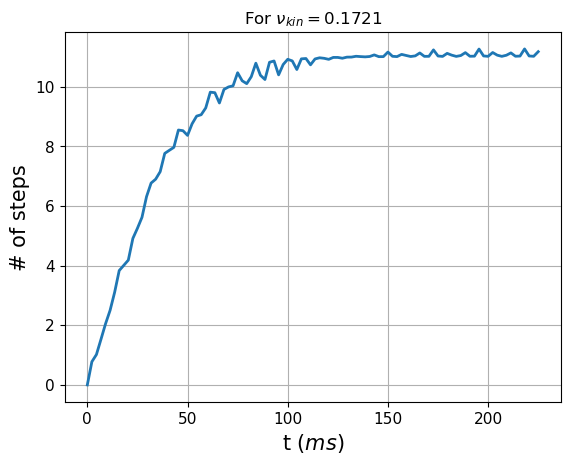

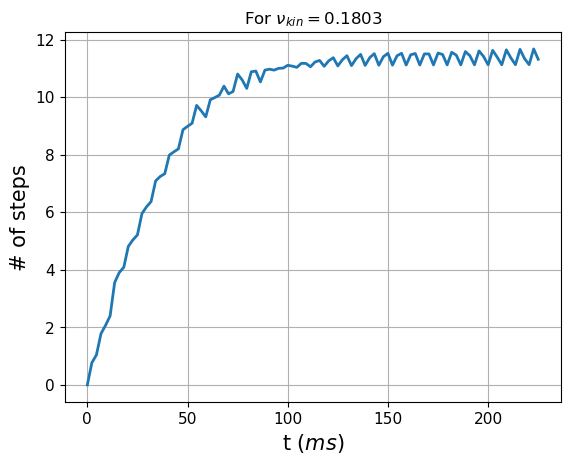

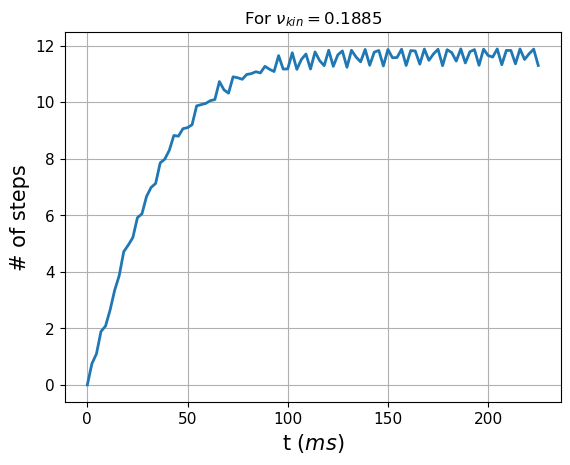

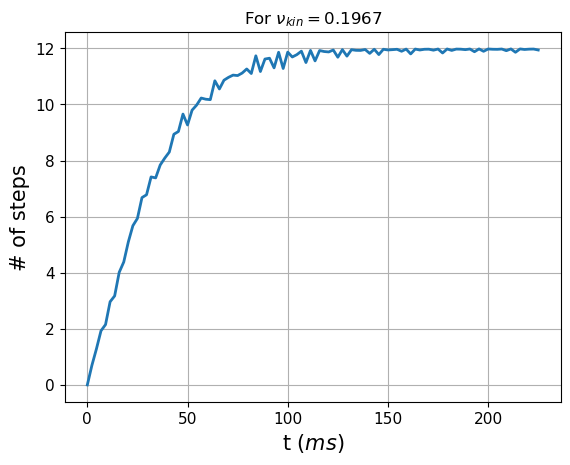

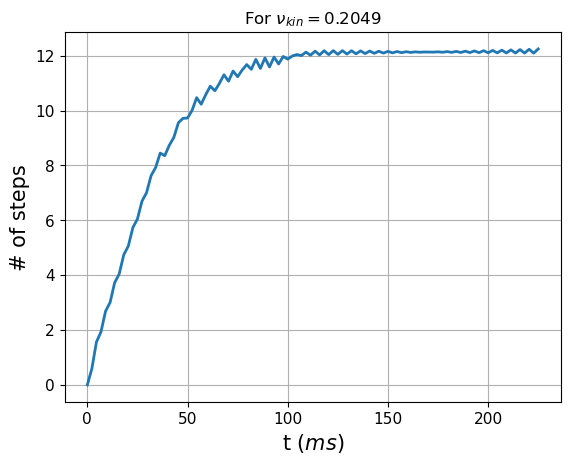

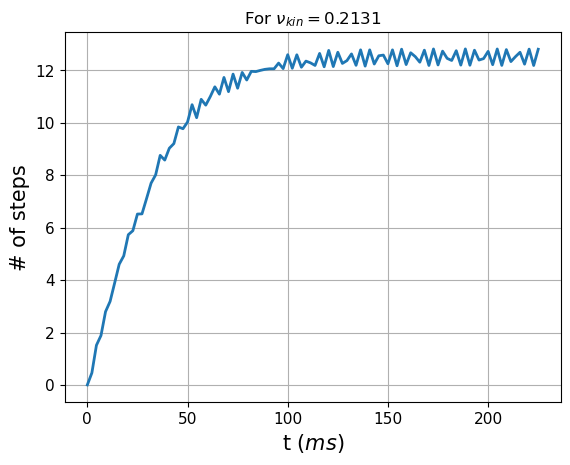

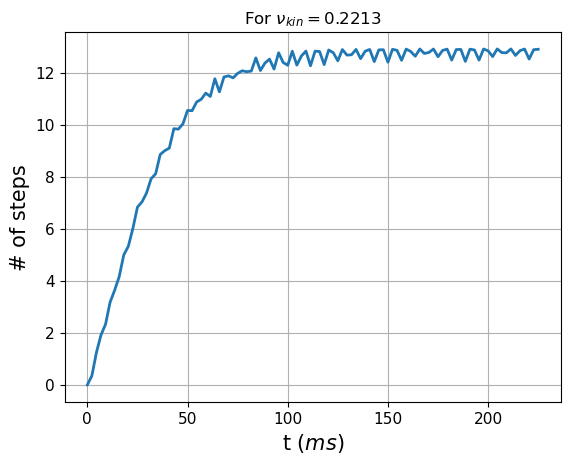

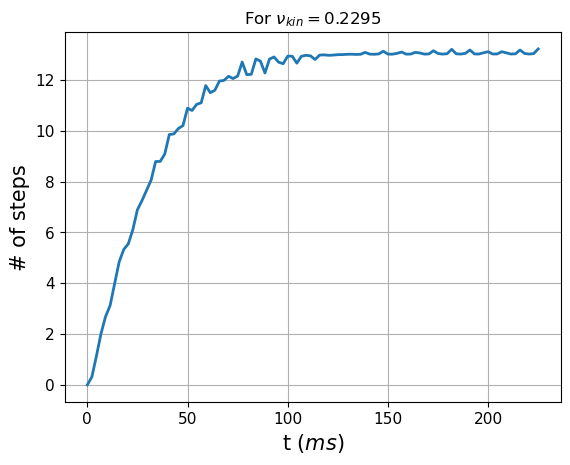

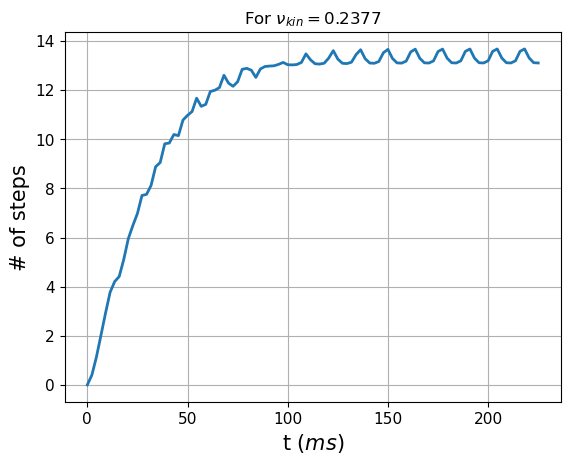

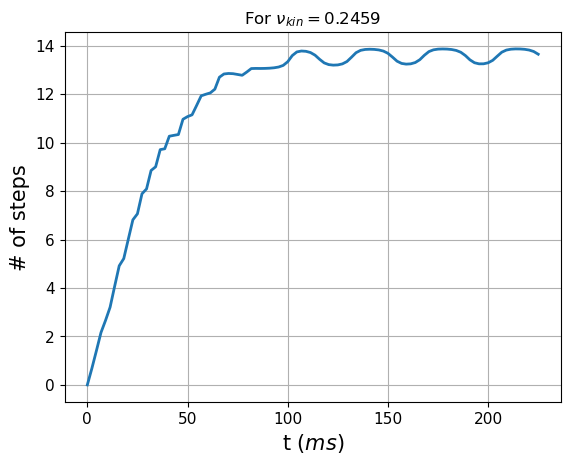

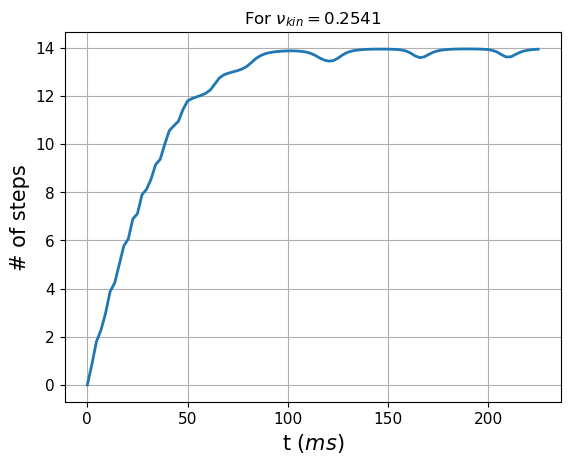

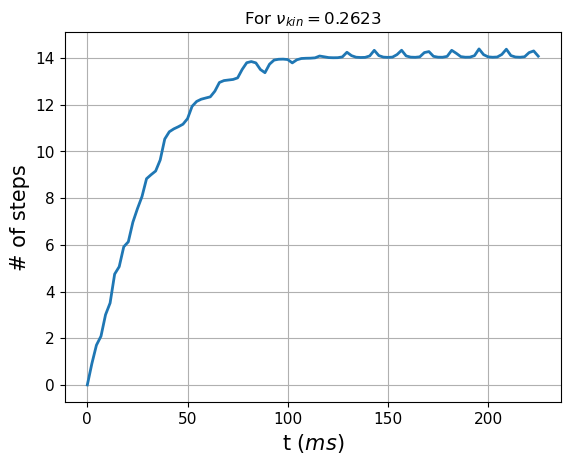

In [118]:
# Looping over a range of nu kinetic values
tlast = tlast_msec * 1000 *1.5
tkeep_1Darr = np.linspace(0,tlast,ntimes)
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])
sigmaI_ref = sigmaI

nruns = 25
nu_kin_mlyperus_range = np.linspace(nu_kin_mlyperus_ref*0.5,nu_kin_mlyperus_ref*2,nruns)
nsteps_for_nu_kin_range = np.empty(0)

# Loop over values of nu_kin
for this_nu_kin_mlyperus in nu_kin_mlyperus_range:

    # Bundle parameters for ODE solver
    scalar_params = np.array([Nbar, Nstar, sigma0, this_nu_kin_mlyperus, Doverdeltax2, tau_eq])
    
    # Initialize as a pre-equilibrated layer of liquid over ice
    Ntot_init_1D = np.ones(nx)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)
    
    # Solve
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,scalar_params,sigmaI_ref,odemethod)
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

    # Number of steps
    nsteps_run = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    nsteps = nsteps_run[-1]
    nsteps_for_nu_kin_range = np.append(nsteps_for_nu_kin_range, nsteps); print(nsteps_for_nu_kin_range)

    # Plot number of steps over time
    nsteps_run = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    plt.figure()
    plt.plot(tkeep_1Darr/1e3,nsteps_run,lw=linewidth)
    plt.xlabel(r't ($m s$)',fontsize=fontsize)
    plt.ylabel('# of steps',fontsize=fontsize)
    plt.grid(True)
    plt.title(r'For $\nu_{kin}=$'+str(np.round(this_nu_kin_mlyperus,4)))

nu_kin_pint 39.341788071548116 micrometer / second
tau_eq_pint 1 microsecond
nu_kin_mlyperus_range_pint [0.06556964678591352 0.07376585263415271 0.08196205848239191 0.0901582643306311 0.09835447017887028 0.10655067602710948 0.11474688187534866 0.12294308772358786 0.13113929357182705 0.13933549942006623 0.14753170526830545 0.1557279111165446 0.16392411696478382 0.172120322813023 0.1803165286612622 0.1885127345095014 0.19670894035774056 0.20490514620597977 0.21310135205421893 0.22129755790245814 0.22949376375069735 0.2376899695989365 0.24588617544717573 0.2540823812954149 0.2622785871436541] / microsecond
[38.30983067  4.34126762]
dNsteps_domega_kin 38.309830670901285 dimensionless


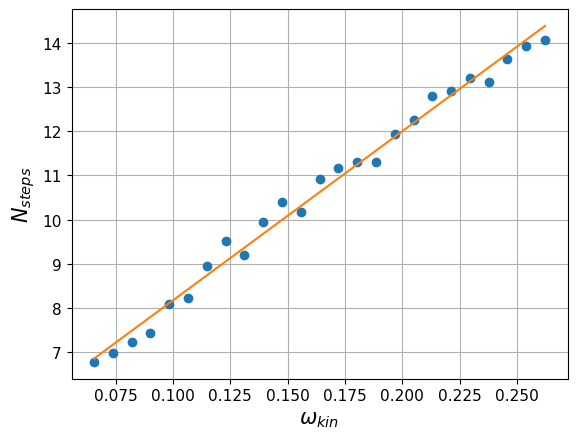

In [23]:
# Analysis of the loop over nu_kin
nu_kin_pint = QLC.get_nu_kin(Temperature,AssignQuantity); print('nu_kin_pint',nu_kin_pint)
tau_eq_pint = AssignQuantity(tau_eq,'microseconds'); print('tau_eq_pint',tau_eq_pint)
nu_kin_mlyperus_range_pint = AssignQuantity(nu_kin_mlyperus_range,'1/microsecond'); print('nu_kin_mlyperus_range_pint',nu_kin_mlyperus_range_pint)
omega_kin_range_pint = tau_eq_pint * nu_kin_mlyperus_range_pint; # print('omega_kin_range_pint',omega_kin_range_pint)
nsteps_for_nu_kin_range_pint = AssignQuantity(nsteps_for_nu_kin_range,'dimensionless')

p = np.polyfit(omega_kin_range_pint.magnitude,nsteps_for_nu_kin_range,1); print(p)
p_omega_kin = p
nsteps_for_nu_kin_range_fit = np.polyval(p,nu_kin_mlyperus_range)
dNsteps_domega_kin = AssignQuantity(p[0],nsteps_for_nu_kin_range_pint.units/omega_kin_range_pint.units); print('dNsteps_domega_kin',dNsteps_domega_kin)

plt.figure()
plt.plot(nu_kin_mlyperus_range,nsteps_for_nu_kin_range,'o')
plt.plot(nu_kin_mlyperus_range,nsteps_for_nu_kin_range_fit)
plt.xlabel(r'$\omega_{kin}$',fontsize=fontsize)
plt.ylabel(r'$N_{steps}$',fontsize=fontsize)
plt.grid(True)

dt = 2272.7272727272725
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.87577919]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.87577919 6.78830217]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.87577919 6.78830217 7.06243458]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.87577919 6.78830217 7.06243458 7.67814742]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.87577919 6.78830217 7.06243458 7.67814742 7.79878503]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.87577919 6.78830217 7.06243458 7.67814742 7.79878503 7.96878986]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[6.87577919 6.78830217 7.06243458

/var/folders/d4/79k8920n66j07rbcltjlhjx00000gr/T/ipykernel_62671/3941834688.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[ 6.87577919  6.78830217  7.06243458  7.67814742  7.79878503  7.96878986
  8.06449053  8.77487779  8.40058633  8.94415442  9.0412224   9.6284351
  9.19774972  9.89167631  9.96202598 10.2235482  10.10047365 10.78048559
 10.81615172 10.83032108 11.01741192 11.3152598 ]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[ 6.87577919  6.78830217  7.06243458  7.67814742  7.79878503  7.96878986
  8.06449053  8.77487779  8.40058633  8.94415442  9.0412224   9.6284351
  9.19774972  9.89167631  9.96202598 10.2235482  10.10047365 10.78048559
 10.81615172 10.83032108 11.01741192 11.3152598  11.5584842 ]
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
[ 6.87577919  6.78830217  7.06243458  7.67814742  7.79878503  7.96878986
  8.06449053  8.77487779  8.40058633  8.94415442  9.0412224   9.6284351
  9.197

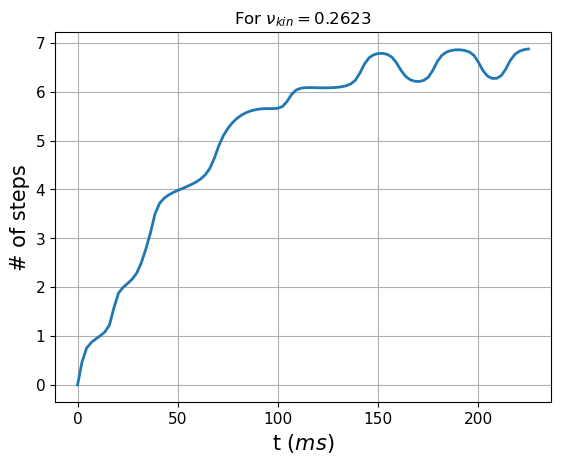

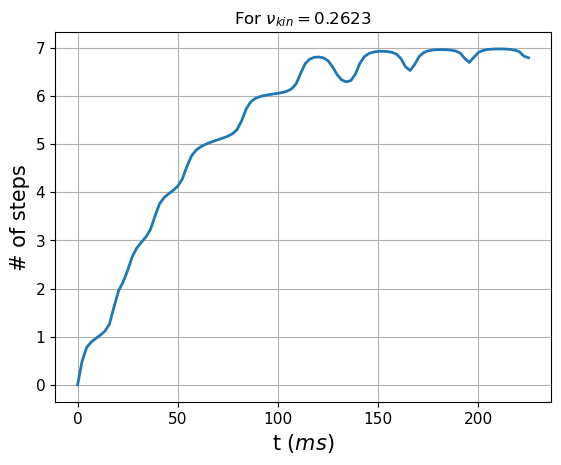

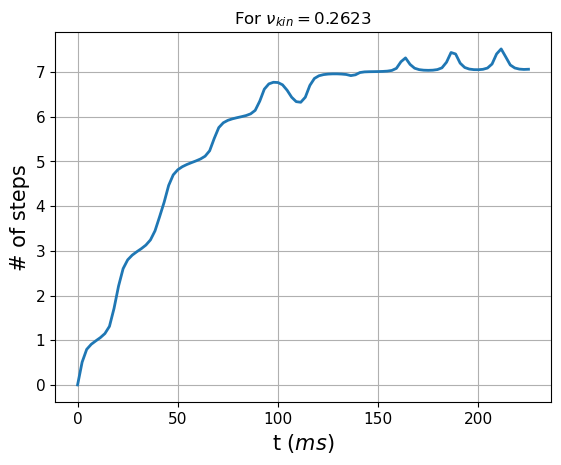

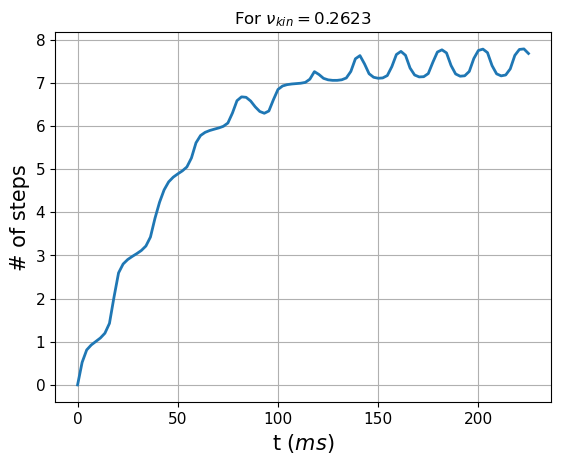

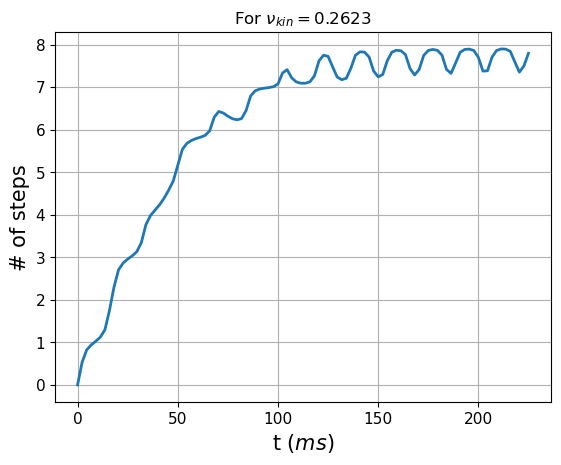

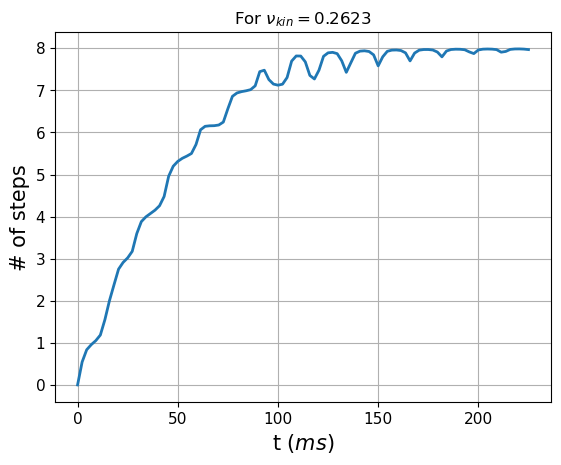

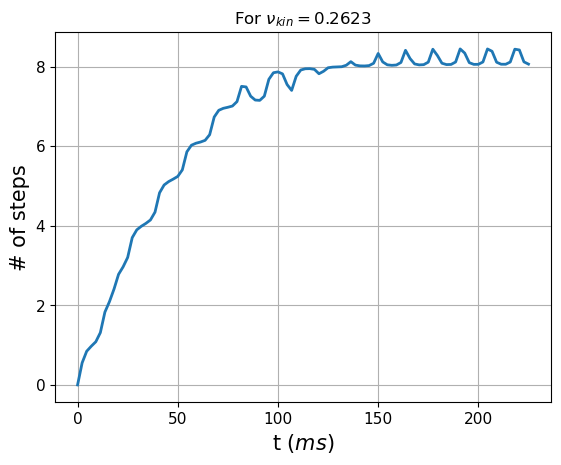

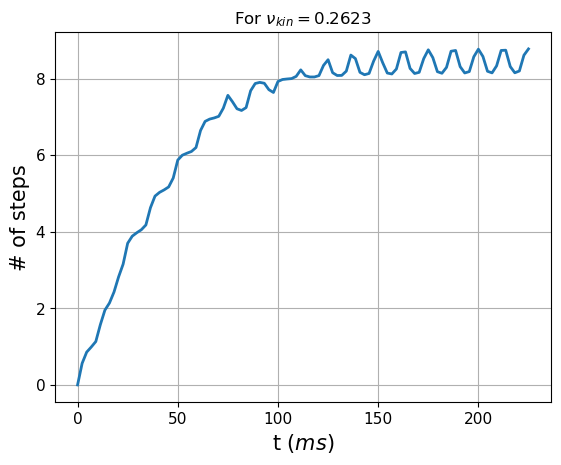

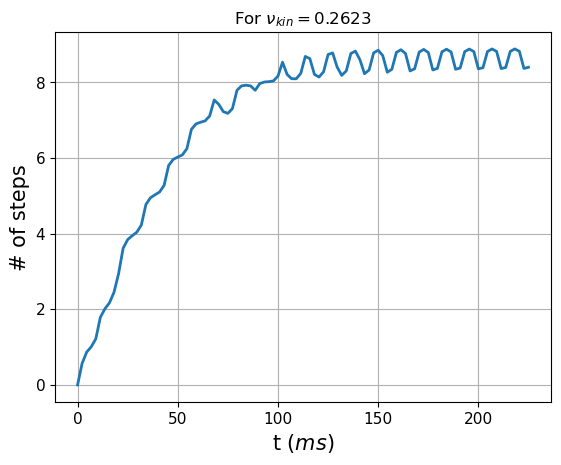

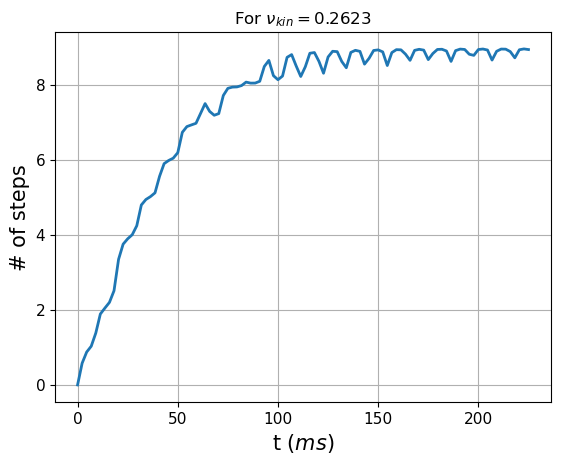

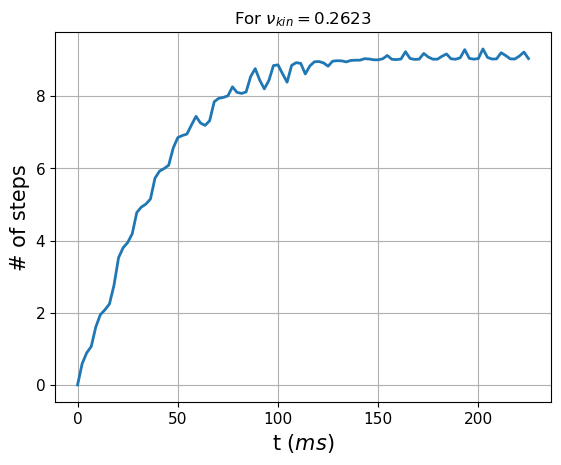

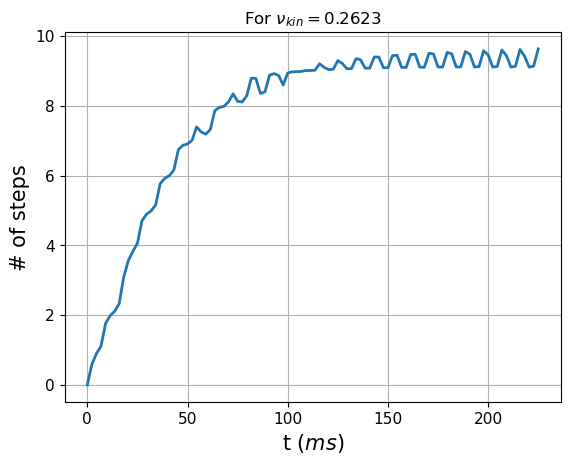

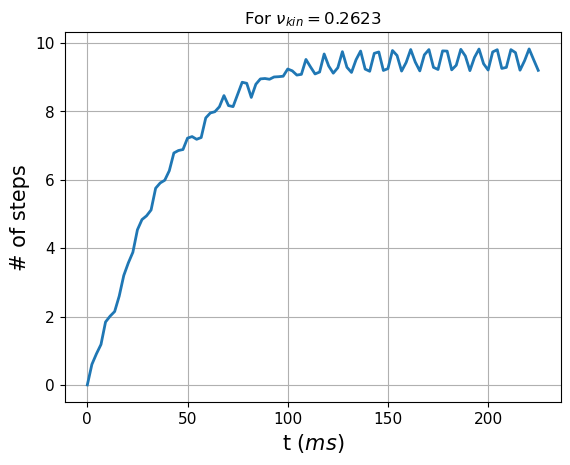

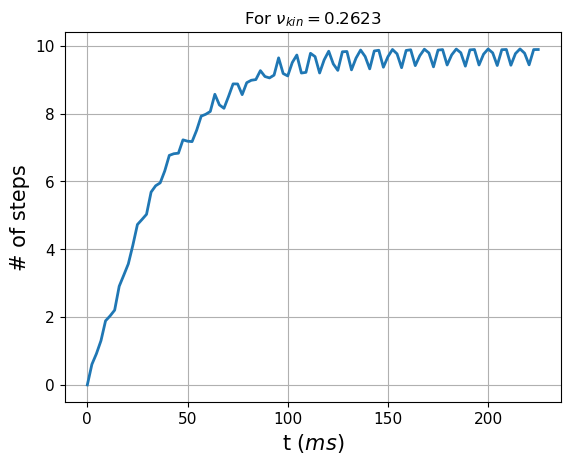

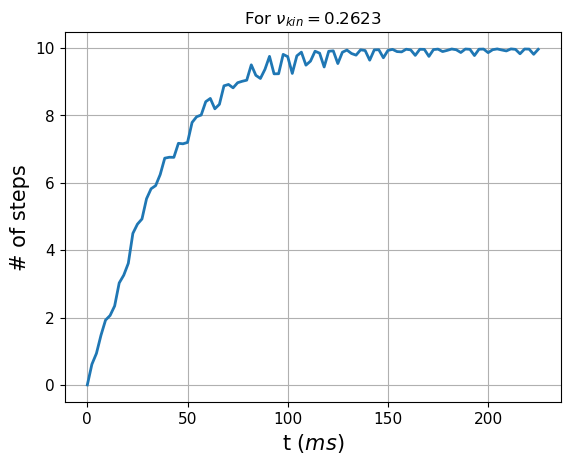

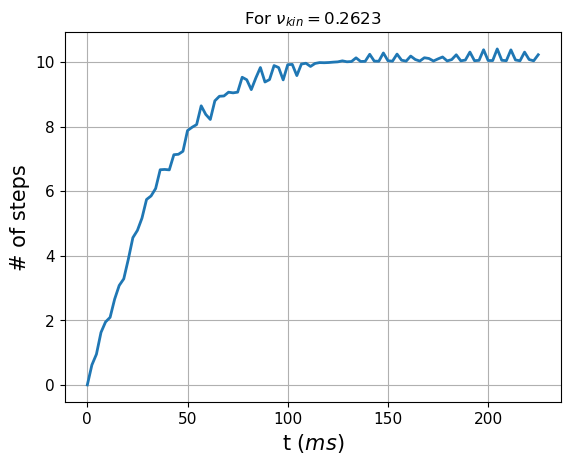

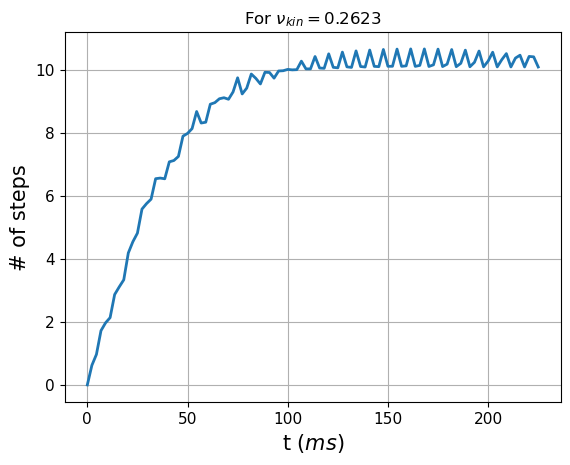

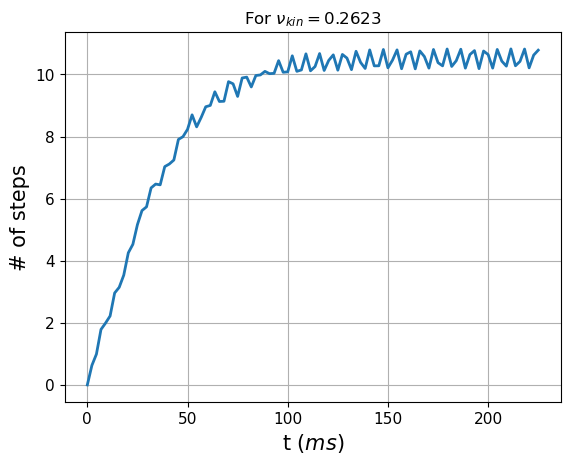

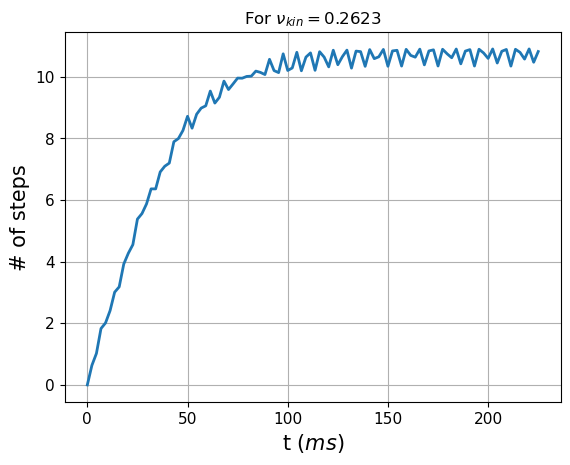

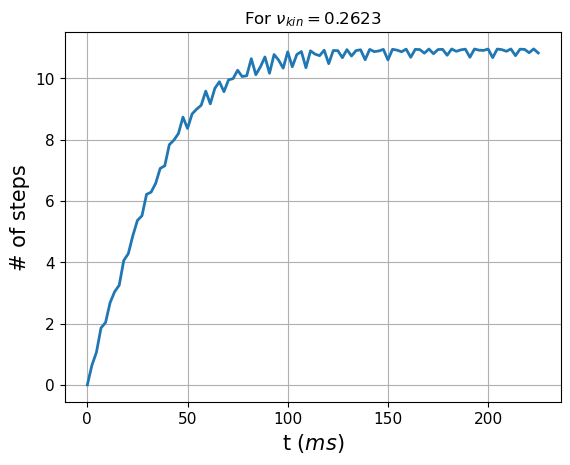

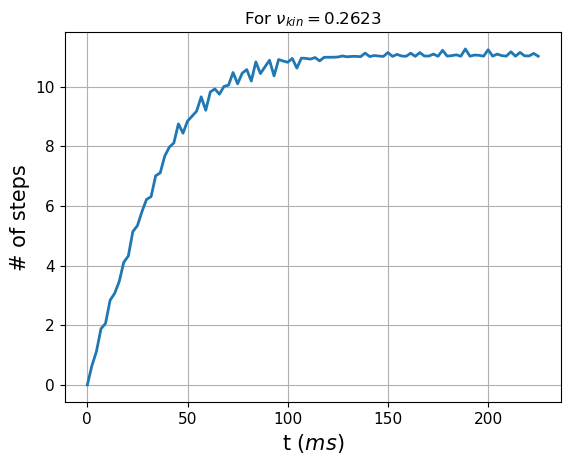

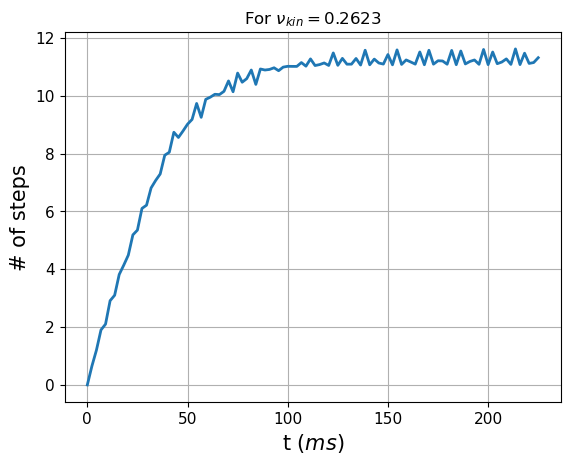

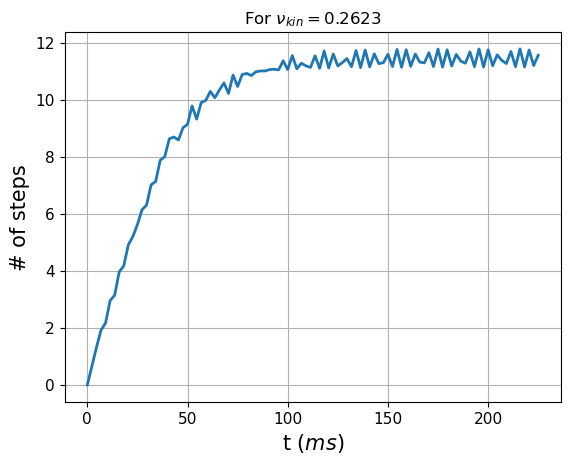

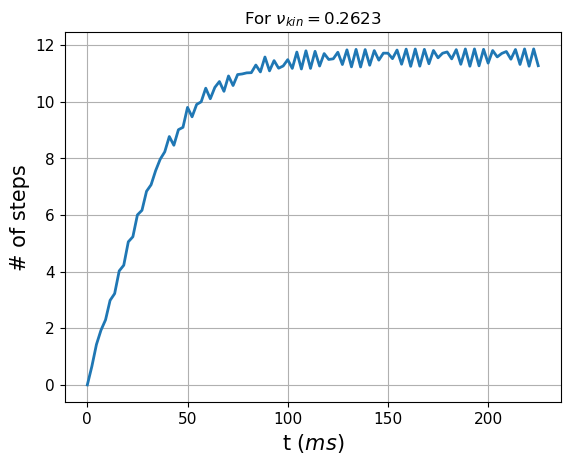

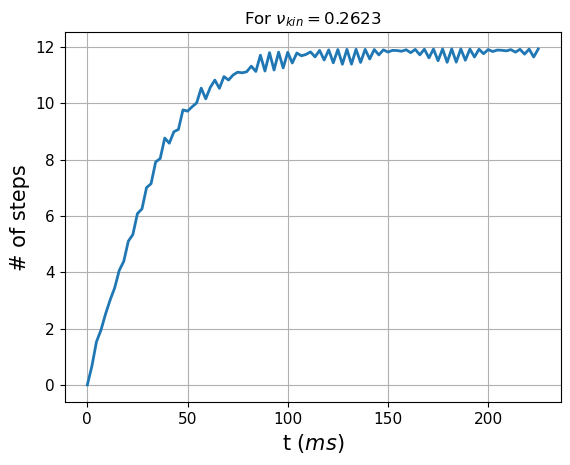

In [24]:
# Looping over a range of center reduction values
tlast = tlast_msec * 1000 *1.5
tkeep_1Darr = np.linspace(0,tlast,ntimes)
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])
center_reduction_ref = center_reduction

nruns = 25
center_reduction_range = np.linspace(center_reduction_ref*.5,center_reduction_ref*1.5,nruns)
nsteps_for_center_reduction_range = np.empty(0)

# Bundle parameters for ODE solver
scalar_params = np.array([Nbar, Nstar, sigma0, nu_kin_mlyperus_ref, Doverdeltax2, tau_eq])

# Loop over values of center_reduction
for this_center_reduction in center_reduction_range:
    
    # Initialize as a pre-equilibrated layer of liquid over ice
    Ntot_init_1D = np.ones(nx)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

    # Re-set the imposed supersaturation according to this center reduction
    this_sigmaI = QLC.getsigmaI(x,xmax,this_center_reduction,sigmaIcorner,method='parabolic')
    
    # Solve
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,scalar_params,this_sigmaI,odemethod)
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

    # Number of steps
    nsteps_run = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    nsteps = nsteps_run[-1]
    nsteps_for_center_reduction_range = np.append(nsteps_for_center_reduction_range, nsteps); print(nsteps_for_center_reduction_range)

    # Plot number of steps over time
    nsteps_run = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    plt.figure()
    plt.plot(tkeep_1Darr/1e3,nsteps_run,lw=linewidth)
    plt.xlabel(r't ($m s$)',fontsize=fontsize)
    plt.ylabel('# of steps',fontsize=fontsize)
    plt.grid(True)
    plt.title(r'For $\nu_{kin}=$'+str(np.round(this_nu_kin_mlyperus,4)))

[13.38812848  4.4027463 ]
dNsteps_dcenter_reduction 13.388128482526179 / percent


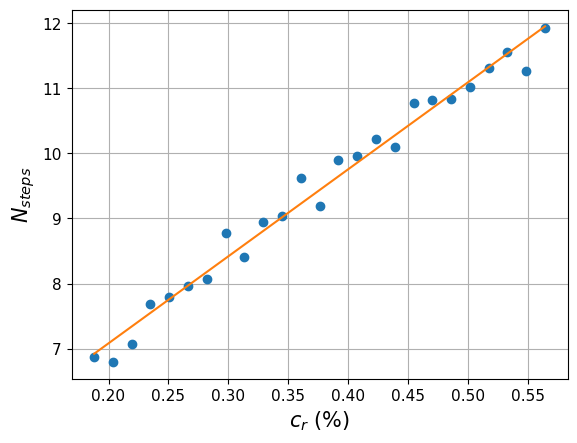

In [25]:
# Analysis of the loop over center_reduction

center_reduction_range_pint = AssignQuantity(center_reduction_range,'percent')
nsteps_for_center_reduction_range_pint = AssignQuantity(nsteps_for_center_reduction_range,'dimensionless')

p = np.polyfit(center_reduction_range_pint.magnitude,nsteps_for_center_reduction_range,1); print(p)
p_center_reduction = p
nsteps_for_center_reduction_range_fit = np.polyval(p,center_reduction_range)
dNsteps_dcenter_reduction = AssignQuantity(p[0],nsteps_for_center_reduction_range_pint.units/center_reduction_range_pint.units); print('dNsteps_dcenter_reduction',dNsteps_dcenter_reduction)

plt.figure()
plt.plot(center_reduction_range,nsteps_for_center_reduction_range,'o')
plt.plot(center_reduction_range,nsteps_for_center_reduction_range_fit)
plt.xlabel(r'$c_r$ (%)',fontsize=fontsize)
plt.ylabel(r'$N_{steps}$',fontsize=fontsize)
plt.grid(True)

### Parameters for the bilinear form for $N_{steps}$
Below, coming up with "m" and "b" for

$$
N_{steps}=m \times \omega_{kin} \times c_r + b \ \ \ (1)
$$

where we're using $c_r$ in % (which in this code is called "center_reduction". The above is possible if, in writing the following, assuming (as we did in the code above) a fixed $\omega_{kin}=\omega_{kin}^{ref}$:

$$
N_{steps}=m_1 \times c_r + b_1 \ \ \ (2)
$$

and similarly assuming a fixed $c_r=c_r^{ref}$

$$
N_{steps}=m_2 \times \omega_{kin} + b_2 \ \ \ (3)
$$

If we find that $b_1 \approx b_2$, and therefore it would have to be the case that

$$
{m_1 \over \omega_{kin}^{ref}} = {m_2 \over c_r^{ref}} \ \ \ (4)
$$

Because there are two ways to find $m$ from this, we'll take the averge:

$$
m = {m_1+m_2 \over 2}
$$

$$
b = {b_1+b_2 \over 2}
$$

We're making pint variables below, just to double-check the units.

In [73]:
# These assignments are to correspond to the notes above
m1 = dNsteps_dcenter_reduction; print('m1', m1)
b1 = p_center_reduction[1]; print('b1', b1)
m2 = dNsteps_domega_kin; print('m2', m2)
b2 = p_omega_kin[1]; print('b2', b2)

# Converting to pint form
nu_kin_mlyperus_ref_pint = AssignQuantity(nu_kin_mlyperus_ref,'1/microsecond'); print('nu_kin_mlyperus_ref_pint',nu_kin_mlyperus_ref_pint)
omega_kin_ref_pint = nu_kin_mlyperus_ref_pint * tau_eq_pint; print('omega_kin_ref_pint',omega_kin_ref_pint)
center_reduction_ref_pint = AssignQuantity(center_reduction_ref,'percent'); print('center_reduction_ref_pint',center_reduction_ref_pint)
nsteps_for_omega_kin_range_pint = nsteps_for_nu_kin_range_pint

# Checking the equivalence of Eq. 4 above
LHS = m1/omega_kin_ref_pint; print('LHS', LHS)
RHS = m2/center_reduction_ref_pint; print('RHS', RHS)

# Parameters for the bilinear form
m_combined = (LHS+RHS)/2; print('m_combined',m_combined)
b_combined = (b1+b2)/2; print('b_combined', b_combined)

# Theoretical values predicted by the bilinear parameters m and b
nsteps_for_center_reduction_range_bilinear_fit = m_combined*omega_kin_ref_pint   *center_reduction_range_pint +b_combined
nsteps_for_omega_kin_range_bilinear_fit =        m_combined*omega_kin_range_pint *center_reduction_ref_pint   +b_combined

m1 13.388128482526179 / percent
b1 4.4027463004954095
m2 38.309830670901285 dimensionless
b2 4.3412676235837635
nu_kin_mlyperus_ref_pint 0.13113929357182705 / microsecond
omega_kin_ref_pint 0.13113929357182705 dimensionless
center_reduction_ref_pint 0.376 percent
LHS 102.09089982014652 / percent
RHS 101.88784752899278 / percent
m_combined 101.98937367456965 / percent
b_combined 4.3720069620395865


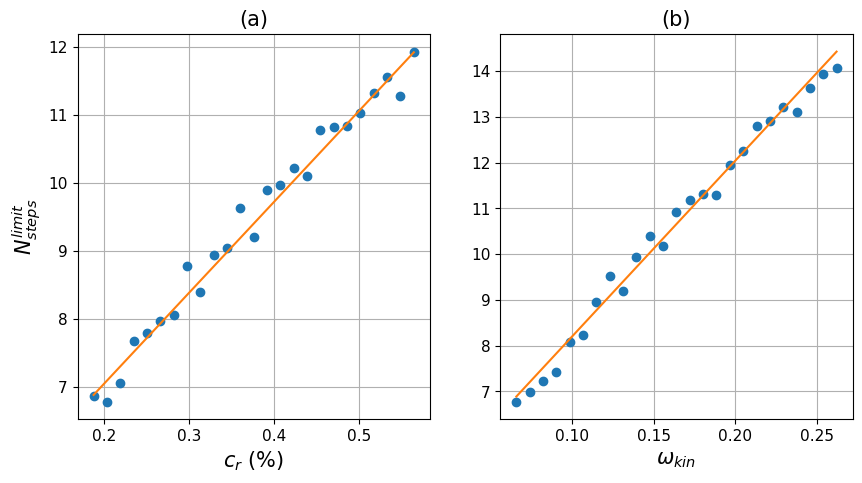

In [206]:
# Constructing & saving these graphs as a combined figure
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(center_reduction_range_pint.magnitude,nsteps_for_center_reduction_range_pint.magnitude,'o')
plt.plot(center_reduction_range_pint.magnitude,nsteps_for_center_reduction_range_bilinear_fit.magnitude)
plt.xlabel(r'$c_r$ (%)',fontsize=fontsize)
plt.ylabel(r'$N_{steps}^{limit}$',fontsize=fontsize)
plt.title('(a)',fontsize=fontsize)
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(omega_kin_range_pint.magnitude,nsteps_for_omega_kin_range_pint.magnitude,'o')
plt.plot(omega_kin_range_pint.magnitude,nsteps_for_omega_kin_range_bilinear_fit.magnitude)
plt.xlabel(r'$\omega_{kin}$',fontsize=fontsize)
# plt.ylabel(r'$N_{steps}^{limit}$',fontsize=fontsize)
plt.title('(b)',fontsize=fontsize)
plt.grid(True)

figurename_Nsteps = 'Figure - Nsteps as a function of omega_kin and c_r.png'
fig.savefig(figurename_Nsteps, dpi=200)